In [237]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import seaborn as sns

from scipy import stats

import visualizor

In [268]:
df = pd.read_csv('../final_data.csv')

In [253]:
df['dt'] = pd.to_datetime(df.publishedAt)
df['comment_date'] = df.dt.dt.date

In [255]:
df['release_date_us_dt'] = pd.to_datetime(df.releaseDateUS)
df['upper_date_lim'] = df.release_date_us_dt + pd.Timedelta(30, "d")
df['lower_date_lim'] = df.release_date_us_dt - pd.Timedelta(30, "d")
df = df[(df.comment_date <= df.upper_date_lim) & (df.comment_date >= df.lower_date_lim)]

In [242]:
df['comment_idx'] = (pd.to_datetime(df.comment_date) - df.release_date_us_dt)
df['comment_idx'] = df.comment_idx.astype(str).str[:-5].astype(int)

<ipython-input-242-de8c7f1fbf1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_idx'] = (pd.to_datetime(df.comment_date) - df.release_date_us_dt)
<ipython-input-242-de8c7f1fbf1e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_idx'] = df.comment_idx.astype(str).str[:-5].astype(int)


In [157]:
annot_params = {
    'color': '#777777',
    'linestyle': '--'
}

plot_dict = {
    True: {
        'color': '#348ABD',
        'label': 'Above average rating'
    },
    
    False: {
        'color': '#E24A33',
        'label': 'Below average rating'
    }
}

window_size=4

157
152


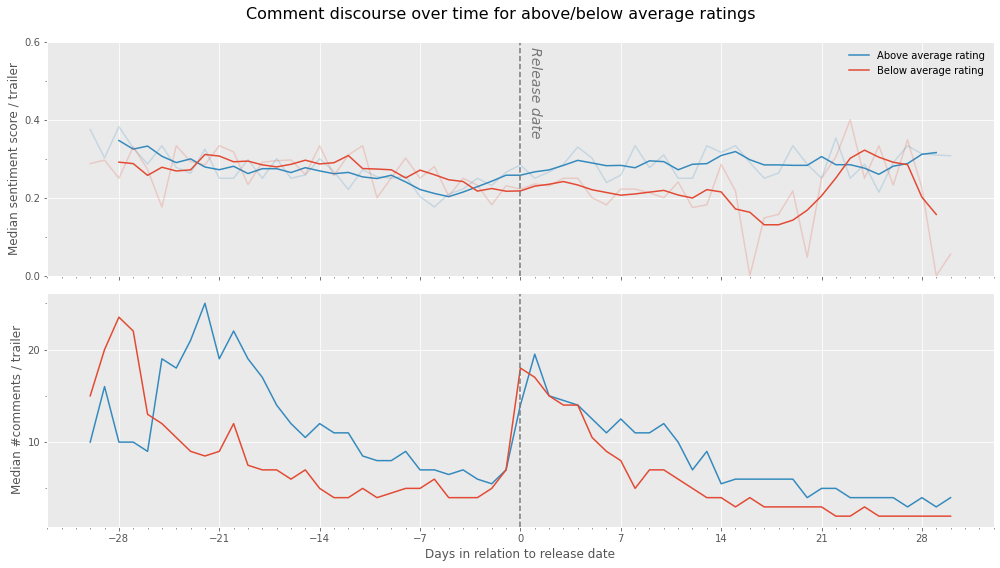

In [236]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14,8))
fig.suptitle('Comment discourse over time for above/below average ratings', fontsize=16)

X = df

# asdf = X.primaryTitle.value_counts().index[X.primaryTitle.value_counts() >= 500]
# X = X[X.primaryTitle.isin(asdf)]

threshold = X[['tconst', 'averageRating']].drop_duplicates().averageRating.median()

mask = X.averageRating >= threshold
X['threshold'] = mask

# X = X[(X.averageRating <= threshold) | (X.averageRating >= threshold)]

for condition in X.threshold.unique():
    mask = X.threshold == condition
    print(X[mask].primaryTitle.nunique())
    Xagg = X[mask].groupby(['comment_idx', 'videoId', 'primaryTitle']).agg(
        sentiment=('sentiment_predicted_score', 'mean'),
        numComments=('commentId', 'count')
    ).reset_index()
    
    Xagg = Xagg.groupby('comment_idx').agg(
        sentiment=('sentiment', 'median'),
        numComments=('numComments', 'median')
    ).reset_index()
    
    trend = Xagg.rolling(window=window_size, center=True).mean().sentiment
   
    trend = ax1.plot(Xagg.comment_idx, trend, **plot_dict[condition])
    ax1.plot(Xagg.comment_idx, Xagg.sentiment, alpha=.2)
    ax2.plot(Xagg.comment_idx, Xagg.numComments)


ax1.set_ylim(0, .6)

ax1.axvline(x=0, **annot_params)
ax1.text(0.5, .36, 'Release date', color=annot_params['color'], fontsize=14, fontstyle='italic', rotation=-90)

ax1.set_ylabel('Median sentiment score / trailer')

ax1.xaxis.set_major_locator(MultipleLocator(7))
ax1.xaxis.set_minor_locator(MultipleLocator(1))

ax1.yaxis.set_major_locator(MultipleLocator(.2))
ax1.yaxis.set_minor_locator(MultipleLocator(.1))
ax1.set_xticklabels([])

    
ax2.axvline(x=0, **annot_params)

ax2.xaxis.set_major_locator(MultipleLocator(7))
ax2.xaxis.set_minor_locator(MultipleLocator(1))

ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(MultipleLocator(5))

ax2.set_xlabel('Days in relation to release date')
ax2.set_ylabel('Median #comments / trailer')

ax1.legend()

plt.tight_layout()

In [207]:
fig.savefig('discourse_time.svg')